# week6_hw PCA and K-means

In [1]:
import jieba
import os
import pandas as pd
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import timedelta, date
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA as PCA
#from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#import plotly.plotly as py
#import plotly.graph_objs as go
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#import plotly.offline as offline
#import plotly.graph_objs as go
#init_notebook_mode(connected=True)

In [3]:
def is_chinese(uchar):         
    if u'\u4e00' <= uchar<=u'\u9fff':
        return True
    else:
        return False

In [4]:
# 專有名詞
jieba.load_userdict('ProperN.txt')

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/bf/kxrhqhkd3s1263kmtf84x8zw0000gn/T/jieba.cache
Loading model cost 0.701 seconds.
Prefix dict has been built succesfully.


In [76]:
folders = ["中電/", "金雨/", "大同/", "中興電/", "聲寶/",  "永大/", "亞力/"]

In [77]:
imp_words = ["經營權",  "董事會",  "請辭", "接任", "出任", "兼任", "辭去", "入主", "推選", "另聘", "市場派", "公司派"]

In [93]:
def get_txts(folder):
    all_files = []
    for f in os.listdir("News/" + folder):
        if not f.startswith('.'):
            all_files.append(f)
    #os.listdir("News/" + folder)   # imagine you're one directory above test dir
    return all_files

In [94]:
with open("StopWords.txt") as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
stopwords = [x.strip() for x in content]

In [80]:
def get_word_dict(filter_list, word_dict):
    word_dict_local = word_dict
    copy_list = filter_list.copy()
    for w in copy_list:
        if (w not in stopwords) :
            if w in word_dict_local:
                word_dict_local[w] = word_dict_local[w] + 1
            else:
                word_dict_local[w] = 1
    return word_dict_local

In [81]:
# 讀取新聞檔案，並使用jieba切詞
def textMining(folder, file):
    with open("./News/" + folder + file, 'rt',encoding="utf-8", errors='ignore') as txt:
        data = txt.read()
    #text segmentation
    seg_list = jieba.cut(data, cut_all=False)
    seg_list = list(seg_list)
    filter_list = []
    jump = False
    for word in seg_list:
        for s in word:
            if not is_chinese(s):
                jump = True
                break
        if not jump:
            filter_list.append(word)
        jump = False
    return filter_list

In [11]:
def analyze(folder, corpus, txts_in_folder):
    # tfidf
    vectorizer = TfidfVectorizer(max_df = 0.9, min_df = 0.2)
    tfidf = vectorizer.fit_transform(corpus)
    words = vectorizer.get_feature_names()
    print("tfidf.shape: ", tfidf.shape)
    for i in range(len(corpus)):
        print('----{0} NEWS----'.format(txts_in_folder[i]))
        for j in range(len(words)):
            if words[j] in imp_words:
                tfidf[i,j] = tfidf[i,j] * 2
            if tfidf[i,j] > 0.2:
                print(words[j], tfidf[i,j], i ,j)
    
    X = tfidf.toarray()
    sklearn_pca = PCA(n_components = 2)
    Y_sklearn = sklearn_pca.fit_transform(X)
    
    return Y_sklearn

In [12]:
def plot_cloud(wordDict):
    font = r"/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf"
    wordcloud = WordCloud(width=2000, height=1000, margin=2 , font_path=font)
    wordcloud.fit_words(wordDict)
    plt.figure(figsize = (12, 10))
    plt.grid(False)
    plt.imshow(wordcloud)

In [13]:
def plot_bar(wordDict):
    items = sorted(wordDict.items(), key = lambda x: x[1], reverse = True)[:10]
    keys = dict(items).keys() #top10_key
    print(keys)
    value = dict(items).values() #top10_value
    print(value)
    plt.figure(figsize = (10, 6))
    plt.bar(range(0,10), value)
    plt.xticks(range(0,10), keys, fontsize = 12)
    plt.ylabel('Frequency', fontsize = 20)
    plt.title("Top 10", fontsize = 20)
    plt.show()

In [14]:
def plot_cpa_scatter(Y_sklearn, txts_in_folder):
    pca_data = [
        go.Scatter(
            x = Y_sklearn[:,0],
            y = Y_sklearn[:,1],
            mode = "markers",
            hoverinfo = 'text',
            text = txts_in_folder
        )
    ]

    fig = go.Figure(data = pca_data)
    return py.iplot(fig, filename = 'PCA Scatter Chart')

In [15]:
import plotly.offline as off

off.init_notebook_mode(connected=False)

def plot_kmeans_scatter(Y_sklearn, txts_in_folder):
    kmeans = KMeans(n_clusters = 3)
    X_clustered = kmeans.fit_predict(Y_sklearn)
    
    #Define our own color map
    LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b', 3: 'y'}
    label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

    # Plot the scatter digram
    plt.figure(figsize = (7,7))
    plt.scatter(Y_sklearn[:,0],Y_sklearn[:,1], c= label_color, alpha=0.5) 
    plt.show()
    
    #Define our own color map

    #LABEL_COLOR_MAP = {0:'red', 1: 'green', 2: 'blue'}
    #label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]
    
    #data = [dict(
        #type = 'scatter',
        #x = Y_sklearn[:,0],
        #y = Y_sklearn[:,1],
        #mode = 'markers',
        #hoverinfo = 'text',
        #text = txts_in_folder,
        #marker = dict(color = label_color)
    #)]
    
    #off.iplot({'data': data}, validate=False)
    
    #pca_data = [
        #go.Scatter(
           # x = Y_sklearn[:,0],
            #y = Y_sklearn[:,1],
            #mode = "markers",
            #hoverinfo = 'text',
            #text = txts_in_folder,
            #marker = dict(color = label_color)
     #   )
    #]

    #fig = go.Figure(data = pca_data)
    #return py.iplot(fig, filename = txts_in_folder[0])

###  分析中電

dict_keys(['照明', '產品', '建築', '智慧', '節能', '開發', '產業', '台灣', '智能', '健康'])
dict_values([87, 30, 25, 25, 24, 22, 17, 16, 16, 16])


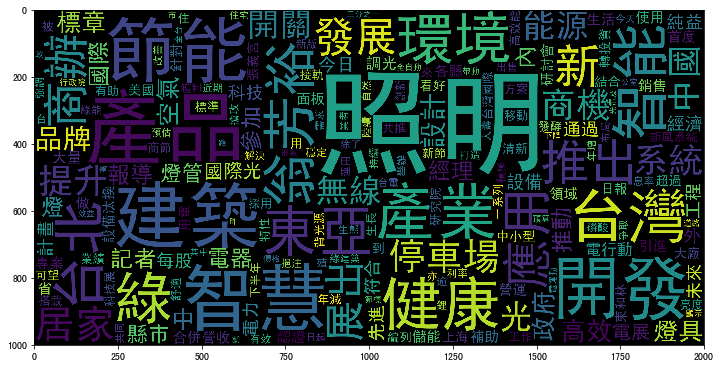

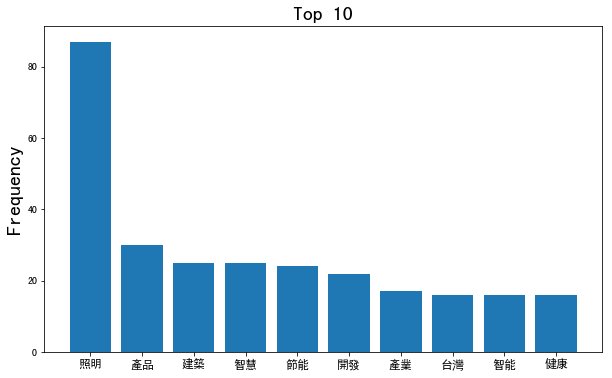

tfidf.shape:  (10, 342)
----20180329_1611_中電去年轉虧為盈.txt NEWS----
儲能 0.2927167835515908 0 37
發展 0.2555921289447062 0 225
結合 0.21953758766369308 0 246
能源 0.20447370315576496 0 259
----20180330_1611_中電漲逾半根停板.txt NEWS----
億元 0.23815451888619119 1 36
公司 0.29827605252735934 1 49
利率 0.22728863966608964 1 58
合併營收 0.22728863966608964 1 78
年增 0.22728863966608964 1 117
----20180410_1611_中國電器轉投資中電開發.txt NEWS----
健康 0.4539249755354452 2 34
建築 0.5160365849803206 2 121
----20180410_1611_中電拓展綠智能新版圖.txt NEWS----
億元 0.22346557518699103 3 36
智能 0.28282550340170426 3 174
----20180425_1611_中電秀先進、智慧、節能產品.txt NEWS----
停車場 0.23146951328053006 4 33
展出 0.20579298424610465 4 106
應用 0.2310171655797321 4 137
----20180426_1611_中電搶57億節能商機.txt NEWS----
停車場 0.22379163257872592 5 33
億元 0.31269600505271167 5 36
產品 0.26715046067731774 5 221
翁芳裕 0.20191761163708563 5 257
通過 0.22379163257872592 5 297
----20180623_1611_中電獲利改善股價走高.txt NEWS----
億元 0.3152403681954692 6 36
合併營收 0.4512861321511958 6 78
息率 0.3008574214341305 6 134

In [66]:
# get corpus from folder 中電
txts_in_folder0 = get_txts(folders[0])
word_dict0 = {}
corpus0 = []

for file_name in txts_in_folder0:
    filter_list = textMining(folders[0], file_name)
    word_dict0 = get_word_dict(filter_list, word_dict0)
    join_list = " ".join(filter_list)
    corpus0.append(join_list)

plot_cloud(word_dict0)
plot_bar(word_dict0)

Y_sklearn0 = analyze(folders[0], corpus0, txts_in_folder0)

In [17]:
#plot_cpa_scatter(Y_sklearn0, txts_in_folder0)

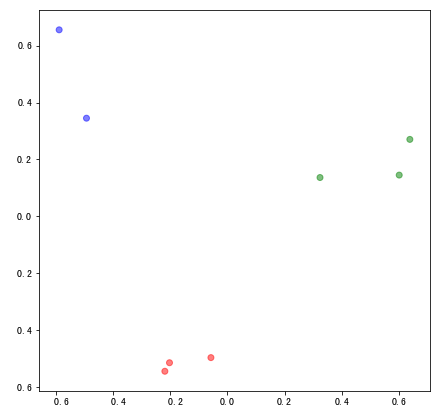

In [37]:
plot_kmeans_scatter(Y_sklearn0, txts_in_folder0)

### 分析金雨

dict_keys(['卓燦然', '董事長', '自動', '販賣機', '卓政懋', '兄弟', '越南', '中心', '投資人', '經理'])
dict_values([25, 20, 19, 19, 18, 18, 14, 13, 13, 11])


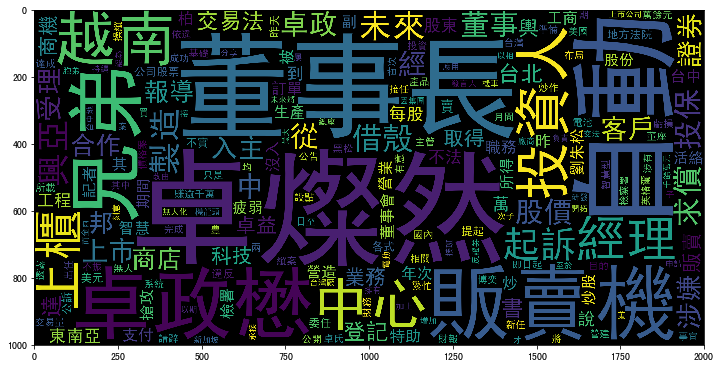

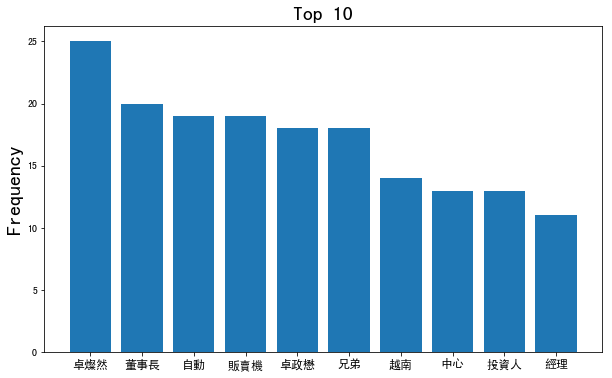

tfidf.shape:  (8, 188)
----20180223_4503_金雨世代交替.txt NEWS----
卓政 0.22552131105739137 0 36
接任 0.2384611510870755 0 85
業務 0.2384611510870755 0 111
自動 0.2794753710717904 0 158
董事長 0.22227007050236802 0 164
販賣機 0.23955031806153457 0 177
----20180412_4503_借殼上市入主金雨.txt NEWS----
上市 0.26281115208753564 1 0
上櫃 0.24364879813968074 1 2
借殼 0.26281115208753564 1 20
兄弟 0.5256223041750713 1 24
入主 0.4872975962793615 1 25
持股 0.21024892167002848 1 84
----20180412_4503_炒作金雨企業股票遭訴.txt NEWS----
上櫃 0.4502245863998873 2 2
交易 0.22200393006575206 2 11
兄弟 0.22200393006575206 2 24
卓燦然 0.3445950316321042 2 38
興亞 0.27750491258219007 2 160
----20180413_4503_金雨前董座涉炒股.txt NEWS----
兄弟 0.30751066753863343 3 24
入主 0.5345421320056144 3 25
卓燦然 0.417653944929095 3 38
董事會 0.30751066753863343 3 163
起訴 0.23865939710234 3 178
----20180530_4503_受理金雨股價操縱案.txt NEWS----
中心 0.29183570161946526 4 7
交易 0.2218997055946689 4 11
交易法 0.2218997055946689 4 12
台北 0.25715041079041717 4 49
投保 0.3214380134880215 4 80
投資人 0.243196418016221 4 82


/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [19]:
# get corpus from folder 金雨
txts_in_folder1 = get_txts(folders[1])
word_dict1 = {}
corpus1 = []

for file_name in txts_in_folder1:
    filter_list = textMining(folders[1], file_name)
    word_dict1 = get_word_dict(filter_list, word_dict1)
    join_list = " ".join(filter_list)
    corpus1.append(join_list)

plot_cloud(word_dict1)
plot_bar(word_dict1)

Y_sklearn1 = analyze(folders[1], corpus1, txts_in_folder1)

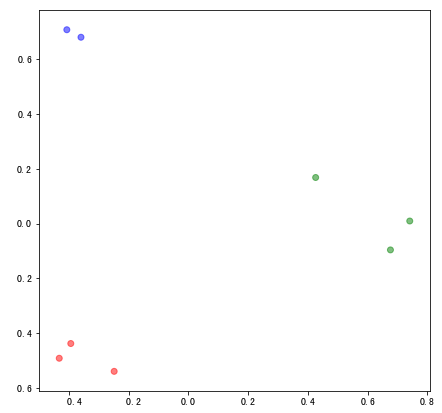

In [20]:
plot_kmeans_scatter(Y_sklearn1, txts_in_folder1)

### 分析大同

dict_keys(['股東', '市場派', '林蔚山', '董事長', '經營權', '董事會', '鄭文逸', '郭文艷', '股價', '董事'])
dict_values([209, 101, 87, 78, 68, 60, 55, 52, 51, 45])


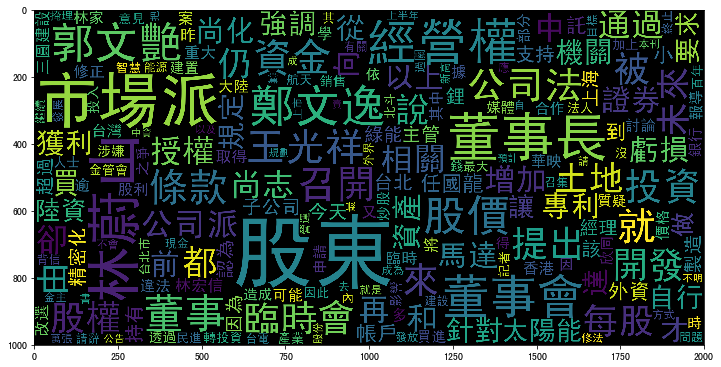

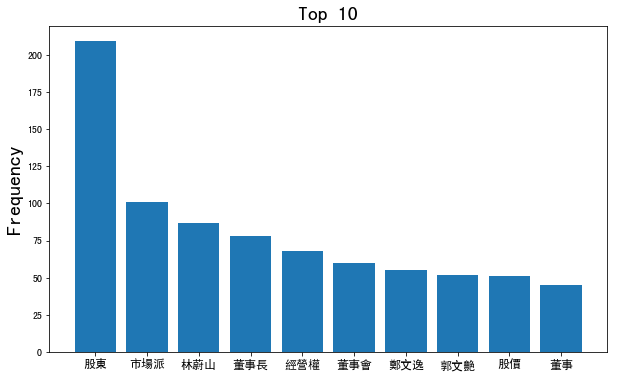

tfidf.shape:  (48, 86)
----237120180313.txt NEWS----
未來 0.6999987812093473 0 40
目前 0.3396556080335958 0 49
表示 0.22363096197598892 0 66
----237120180324.txt NEWS----
億元 0.2566907460154171 1 8
市場派 0.23360180493273855 1 29
經營權 0.3850361190231256 1 52
經理 0.2703835987594637 1 53
股權 0.2453164940520098 1 57
股票 0.6541773174720262 1 58
買進 0.2703835987594637 1 72
----237120180326.txt NEWS----
公司 0.5453948482171005 2 9
機關 0.35625457818714495 2 43
開發 0.5166108219344926 2 84
----237120180328.txt NEWS----
今年 0.23512528587375803 3 4
市場派 0.7786657224016891 3 29
林蔚山 0.6148640513800937 3 41
董事長 0.2162960340004692 3 64
----237120180330.txt NEWS----
指出 0.3124906708348111 4 35
改選 0.49969249490812345 4 37
條款 0.24112927889806118 4 42
申請 0.24984624745406173 4 47
股東 0.5591405479108157 4 56
董事會 0.351904308658031 4 63
重大 0.22568616472805492 4 82
----237120180621.txt NEWS----
公司 0.24987051019812218 5 9
提出 0.6105680293750572 5 36
林蔚山 0.2505364040483322 5 41
董事長 0.2115200475165633 5 64
規定 0.3382340342650065 5 68
資金

/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.




公司 0.2968809586014229 32 9
取得 0.44994019739249097 32 17
林蔚山 0.35720655985908933 32 41
股東 0.4047112866355158 32 56
董事會 0.5094234215769653 32 63
通過 0.20489479173729713 32 78
----林蔚山挨告背信_180201_自由時報.txt NEWS----
合作 0.44587198319653315 33 21
尚志 0.483307500701939 33 26
相關 0.3123371854778246 33 50
股東 0.24945852451559267 33 56
臨時會 0.21469526649771561 33 60
董事會 0.6280033164220752 33 63
通過 0.22732984576421403 33 78
----林蔚山背信掏空_180201_中國時報.txt NEWS----
公司 0.4248404324342059 34 9
提出 0.20762272860813133 34 36
林蔚山 0.42597261338286685 34 41
股東 0.2681236134410419 34 56
董事會 0.8099904484515776 34 63
通過 0.24433921353321364 34 78
----林蔚山辭大同董事長_180201_鉅亨網.txt NEWS----
強調 0.247699128842006 35 30
投入 0.26548230302571135 35 31
林蔚山 0.5243941555285628 35 41
綠能 0.2562198029432347 35 54
董事會 0.4985699125452875 35 63
董事長 0.44272957902521665 35 64
集團 0.2324658154307933 35 85
----林蔚山辭大同董座_180202_自由時報.txt NEWS----
報導 0.23035482041475222 36 24
強調 0.23035482041475222 36 30
投資 0.41959801082979065 36 32
是否 0.216188169156

In [82]:
# get corpus from folder 大同
txts_in_folder2 = get_txts(folders[2])
word_dict2 = {}
corpus2 = []

for file_name in txts_in_folder2:
    filter_list = textMining(folders[2], file_name)
    word_dict2 = get_word_dict(filter_list, word_dict2)
    join_list = " ".join(filter_list)
    corpus2.append(join_list)
    
plot_cloud(word_dict2)
plot_bar(word_dict2)

Y_sklearn2 = analyze(folders[2], corpus2, txts_in_folder2)

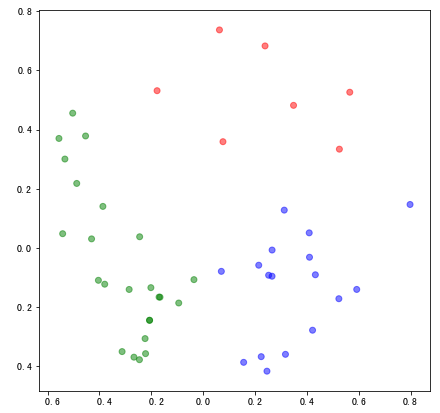

In [83]:
plot_kmeans_scatter(Y_sklearn2, txts_in_folder2)

### 分析中興電 

dict_keys(['開發', '離岸風電', '簽署', '風場', '容量', '基礎', '遴選', '上緯', '能源', '合作'])
dict_values([32, 27, 16, 12, 10, 10, 9, 9, 9, 8])


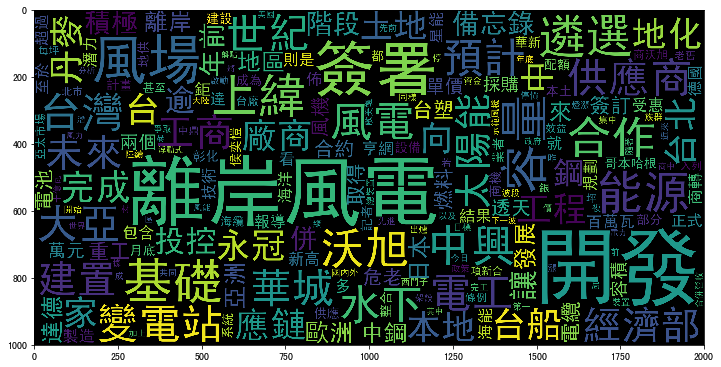

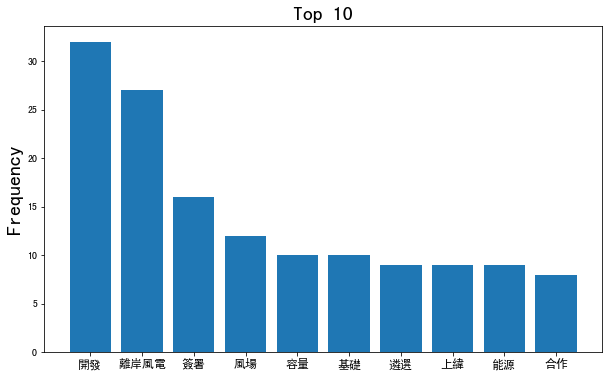

tfidf.shape:  (7, 149)
----201803291513風電遴選題材發酵.txt NEWS----
上緯 0.29110420070934484 0 0
合作 0.27941102030537357 0 41
建置 0.26150852282160103 0 72
簽署 0.24258683392445404 0 106
遴選 0.24258683392445404 0 130
風電 0.3922627842324015 0 148
----201803311513中興電 配息率達86.21％.txt NEWS----
中興電 0.40273626274914875 1 4
今年 0.23193540281694808 1 11
億元 0.5291785562472412 1 16
去年 0.2713434697135612 1 34
工商 0.46387080563389615 1 67
時報 0.46387080563389615 1 86
----201804051513風電開發商 集結台灣打前哨戰.txt NEWS----
台灣 0.3452965903156897 2 39
日本 0.20717795418941382 2 84
發展 0.20717795418941382 2 101
開發 0.3556733341498701 2 134
離岸 0.20717795418941382 2 137
離岸風電 0.40404189863107576 2 138
----201804091513離岸風電題材續航 華城、大亞、中興電股價齊創波段新高.txt NEWS----
受惠 0.21864004060741668 3 36
大亞 0.24338416804679144 3 60
建置 0.21864004060741668 3 72
成為 0.21864004060741668 3 76
經濟部 0.2803293881204874 3 110
設備 0.21864004060741668 3 124
開發 0.2502339354453587 3 134
離岸風電 0.28426363371021274 3 138
----201806261513外商啟動離岸風電在地佈局 吹響與台廠簽約號角.txt NEWS----
供應商 0.2

In [23]:
# get corpus from folder 中興電
txts_in_folder3 = get_txts(folders[3])
word_dict3 = {}
corpus3 = []

for file_name in txts_in_folder3:
    filter_list = textMining(folders[3], file_name)
    word_dict3 = get_word_dict(filter_list, word_dict3)
    join_list = " ".join(filter_list)
    corpus3.append(join_list)

plot_cloud(word_dict3)
plot_bar(word_dict3)

Y_sklearn3 = analyze(folders[3], corpus3, txts_in_folder3)

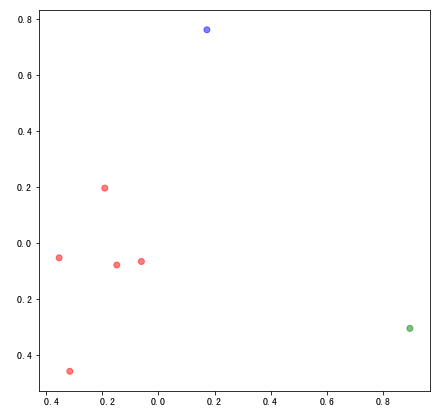

In [24]:
plot_kmeans_scatter(Y_sklearn3, txts_in_folder3)

### 分析聲寶

dict_keys(['陳盛沺', '成長', '平台', '台南', '台灣', '預計', '消費者', '昨日', '投資', '增加'])
dict_values([23, 13, 11, 9, 9, 8, 8, 7, 7, 7])


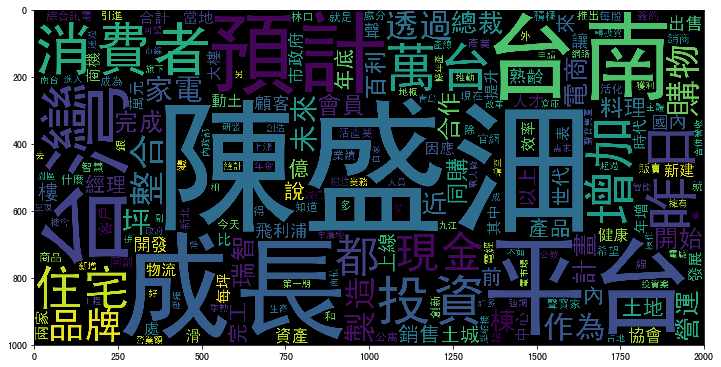

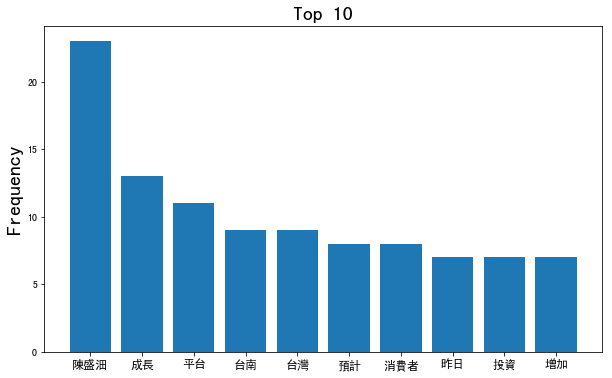

tfidf.shape:  (7, 147)
----160420180129.txt NEWS----
台南 0.5766834827377865 0 32
投資 0.41191677338413324 0 67
----160420180203.txt NEWS----
今年 0.5775646674501907 1 7
去年 0.420047030872866 1 28
增加 0.24190465651771537 1 46
聲寶 0.24292618385443523 1 115
----160420180321.txt NEWS----
世代 0.23558695390828704 2 1
今年 0.23311023348534907 2 7
平台 0.3356198640712763 2 59
成長 0.46622046697069813 2 66
整合 0.26849589125702106 2 78
----160420180326.txt NEWS----
健康 0.2230428546623805 3 14
台灣 0.3310470151150252 3 33
商機 0.2230428546623805 3 39
熟齡 0.33456428199357074 3 96
產業 0.2230428546623805 3 104
發展 0.2230428546623805 3 107
開創 0.2230428546623805 3 135
----160420180518.txt NEWS----
公司 0.29536515768804095 4 20
合作 0.22680065727989696 4 34
提供 0.29536515768804095 4 72
消費者 0.22680065727989696 4 95
簽約 0.2653362812757559 4 110
開始 0.3980044219136339 4 136
顧客 0.2653362812757559 4 145
----160420180621.txt NEWS----
住宅 0.2118761520064091 5 10
出售 0.2141272672189927 5 24
去年 0.2118761520064091 5 28
土地 0.2141272672189927 5 4

In [25]:
# get corpus from folder 聲寶
txts_in_folder4 = get_txts(folders[4])
word_dict4 = {}
corpus4 = []

for file_name in txts_in_folder4:
    filter_list = textMining(folders[4], file_name)
    word_dict4 = get_word_dict(filter_list, word_dict4)
    join_list = " ".join(filter_list)
    corpus4.append(join_list)

plot_cloud(word_dict4)
plot_bar(word_dict4)

Y_sklearn4 = analyze(folders[4], corpus4, txts_in_folder4)

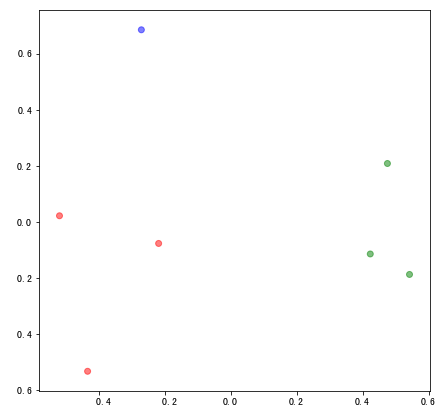

In [26]:
plot_kmeans_scatter(Y_sklearn4, txts_in_folder4)

### 分析東元 

In [27]:
# get corpus from folder 東元
#txts_in_folder5 = get_txts(folders[5])
#word_dict5 = {}
#corpus5 = []

#for file_name in txts_in_folder5:
    #filter_list = textMining(folders[5], file_name)
    #word_dict5 = get_word_dict(filter_list, word_dict5)
    #join_list = " ".join(filter_list)
    #corpus5.append(join_list)

#plot_cloud(word_dict5)
#plot_bar(word_dict5)

#Y_sklearn5 = analyze(folders[5], corpus5, txts_in_folder5)

In [28]:
#plot_kmeans_scatter(Y_sklearn5, txts_in_folder5)

### 分析永大 

dict_keys(['收購', '日立', '股東', '許作名', '公告', '市場派', '經營權', '公開', '董事會', '董事長'])
dict_values([78, 58, 49, 48, 46, 41, 39, 38, 37, 29])


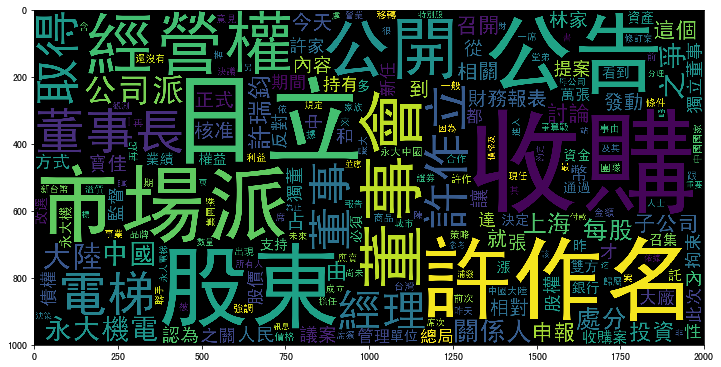

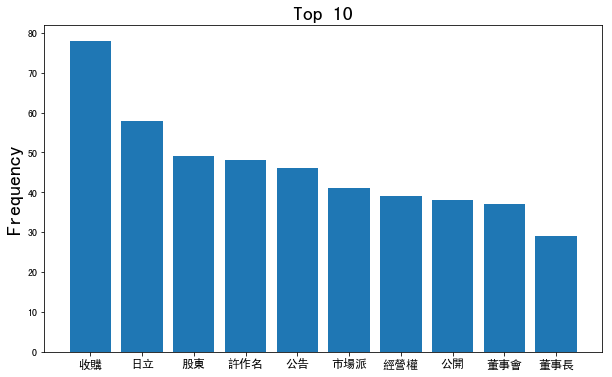

tfidf.shape:  (26, 50)
----201801141507代重要子公司永大(中國)公告取得理財商品.txt NEWS----
交易 0.8377830429229108 0 3
公司 0.2141302205381264 0 6
本次 0.3723480190768493 0 27
----201801311507永大 比價效應突破季線.txt NEWS----
大陸 0.6559608622038356 1 13
市場 0.4159592352474493 1 15
永大 0.3308173031133114 1 30
電梯 0.5359600487256424 1 49
----2018021215071月合併營收15億元 年增5.89%.txt NEWS----
公告 0.40002439761368 2 8
永大機電 0.9165044906130096 2 31
----2018031215072月營收12億5840萬元，月增率-16.10%.txt NEWS----
永大 0.5074743211850171 3 30
永大機電 0.8616668807246836 3 31
----201803151507永大機電董事會決議召開107年股東常會相關事宜.txt NEWS----
公司 0.22339466344695857 4 6
永大機電 0.31374181326294365 4 31
相關 0.21966479467104125 4 35
股東 0.6999232840523694 4 39
董事 0.3815022811578967 4 41
董事會 0.5957191025252229 4 42
----201803161507子公司永大(中國)處分理財商品，獲利31萬人民幣.txt NEWS----
交易 0.8377830429229108 5 3
公司 0.2141302205381264 5 6
本次 0.3723480190768493 5 27
----201803161507永大配現金2元.txt NEWS----
每股 0.5834232154938628 6 29
永大 0.36011358529854876 6 30
董事會 0.8707534873407708 6 42
電梯 0.5834232154

/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [95]:
# get corpus from folder 永大
txts_in_folder5 = get_txts(folders[5])
word_dict5 = {}
corpus5 = []

for file_name in txts_in_folder5:
    filter_list = textMining(folders[5], file_name)
    word_dict5 = get_word_dict(filter_list, word_dict5)
    join_list = " ".join(filter_list)
    corpus5.append(join_list)

plot_cloud(word_dict5)
plot_bar(word_dict5)

Y_sklearn5 = analyze(folders[5], corpus5, txts_in_folder5)

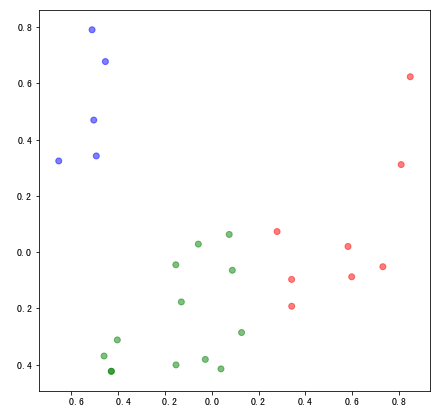

In [96]:
plot_kmeans_scatter(Y_sklearn5, txts_in_folder5)

### 分析亞力 

dict_keys(['股價', '季線', '族群', '台股', '操作', '投資', '選股', '楊基政', '震盪', '離岸風電'])
dict_values([6, 5, 5, 4, 4, 4, 3, 3, 3, 3])


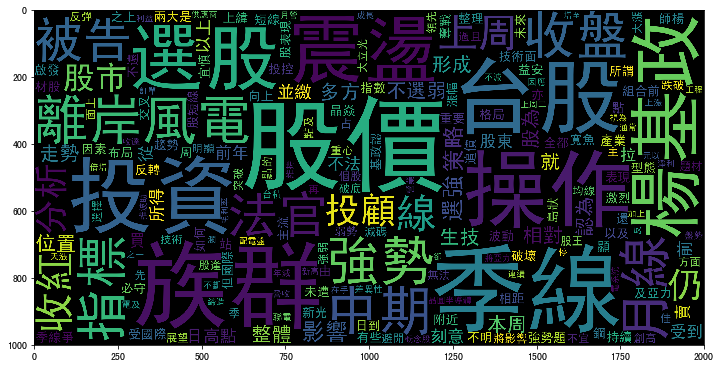

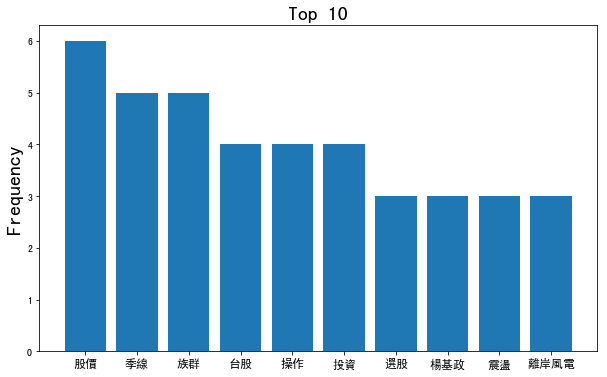

tfidf.shape:  (3, 261)
----151420180401.txt NEWS----
台股 0.22518896256638243 0 64
季線 0.28148620320797807 0 85
族群 0.28148620320797807 0 139
而言 0.22518896256638243 0 200
----151420180408.txt NEWS----
亞力 0.2081599413924259 1 20
以上 0.2081599413924259 1 24
億元 0.6244798241772778 1 38
前年 0.2081599413924259 1 51
----151420180426.txt NEWS----
投資 0.20003249990719948 2 119
法官 0.26301869885737256 2 161
被告 0.26301869885737256 2 214


In [31]:
# get corpus from folder 亞力
txts_in_folder6 = get_txts(folders[6])
word_dict6 = {}
corpus6 = []

for file_name in txts_in_folder6:
    filter_list = textMining(folders[6], file_name)
    word_dict6 = get_word_dict(filter_list, word_dict6)
    join_list = " ".join(filter_list)
    corpus6.append(join_list)

plot_cloud(word_dict6)
plot_bar(word_dict6)

Y_sklearn6 = analyze(folders[6], corpus6, txts_in_folder6)

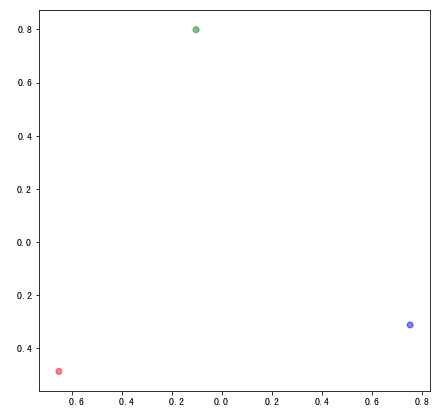

In [32]:
plot_kmeans_scatter(Y_sklearn6, txts_in_folder6)

In [97]:
def analyze1(comapny, corpus, txts_all):
    # tfidf
    vectorizer = TfidfVectorizer(max_df = 0.9, min_df = 0.2)
    tfidf = vectorizer.fit_transform(corpus)
    words = vectorizer.get_feature_names()
    print("tfidf.shape: ", tfidf.shape)
    for i in range(len(corpus)):
        print('----{0} NEWS----'.format(txts_all[i]), comapny[i])
        for j in range(len(words)):
            if words[j] in imp_words:
                tfidf[i,j] = tfidf[i,j] * 2
            if tfidf[i,j] > 0.2:
                print(words[j], tfidf[i,j], i ,j)
    
    X = tfidf.toarray()
    sklearn_pca = PCA(n_components = 2)
    Y_sklearn = sklearn_pca.fit_transform(X)
    
    return Y_sklearn

In [98]:
all_corpus = []
company_names = []
texts_all = []

for i in range(len(folders)):
    corpus = eval("corpus" + str(i))
    names = [folders[i]] * len(corpus)
    all_corpus += corpus
    company_names += names
    texts_all += eval("txts_in_folder" + str(i))

Y_sklearn_all = analyze1(company_names, all_corpus, texts_all)

tfidf.shape:  (109, 50)
----20180329_1611_中電去年轉虧為盈.txt NEWS---- 中電/
企業 0.3754886391832069 0 3
去年 0.28868143110307765 0 10
台灣 0.437444784464162 0 14
市場 0.2575560074132074 0 19
每股 0.34227147021986315 0 27
經營 0.23502783681784087 0 31
針對 0.2545493781225814 0 47
開發 0.3280835883481215 0 48
----20180330_1611_中電漲逾半根停板.txt NEWS---- 中電/
億元 0.4227973084184489 1 4
公司 0.3160109430951114 1 5
去年 0.44312162975586666 1 10
台北 0.3357355633843135 1 13
市場 0.26356305015822873 1 19
開發 0.3357355633843135 1 48
----20180410_1611_中國電器轉投資中電開發.txt NEWS---- 中電/
今年 0.3786680218781781 2 1
台灣 0.27062397800688454 2 14
開發 0.8118719340206535 2 48
----20180410_1611_中電拓展綠智能新版圖.txt NEWS---- 中電/
今年 0.21331446529360273 3 1
億元 0.5332861632340069 3 4
包括 0.2815687050329452 3 9
台灣 0.2540836380366356 3 14
市場 0.29919555420873784 3 19
開發 0.5081672760732712 3 48
----20180425_1611_中電秀先進、智慧、節能產品.txt NEWS---- 中電/
今天 0.29213179380171345 4 0
今年 0.4285881248915853 4 1
億元 0.4285881248915853 4 4
其中 0.29706078433085936 4 7
去年 0.22459540850246

/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



0.24790740481667983 42 34
----大同首位女董座_180202_udn新聞網.txt NEWS---- 大同/
大同 0.8304541002288519 43 18
市場派 0.4978025785224362 43 20
董事會 0.36176226854540006 43 39
郭文艷 0.2507427924247591 43 46
----工研院合作開發馬達驅動器20180914.txt NEWS---- 大同/
合作 0.2178724707998037 44 15
大同 0.5671504670856579 44 18
市場 0.4702906269541842 44 19
未來 0.30803306091842125 44 26
開發 0.4992268089806045 44 48
----市場派有8成把握拿下大同_180131_壹週刊.txt NEWS---- 大同/
公司派 0.2494248687984938 45 6
其他 0.2616420719797016 45 8
去年 0.20115444222274279 45 10
大同 0.37102027181981073 45 18
市場派 1.056410616479856 45 20
持股 0.21128212329597118 45 23
目前 0.32937699058802045 45 29
經營權 0.2060947254170375 45 32
股權 0.25740775590407344 45 36
記者 0.25333953488365907 45 42
----市場派農曆年後奇襲_180131_壹週刊.txt NEWS---- 大同/
公司派 0.2296085883813577 46 6
去年 0.21603533643566378 46 10
召開 0.280997687255988 46 12
大同 0.4553913236948184 46 18
市場派 1.037313086197428 46 20
經營權 0.37944186723481405 46 32
股東 0.4357948875858947 46 35
董事會 0.47114653409446244 46 39
----引陸資炒大同股票 三人被訴20180901.txt N

----201815070315永大機電董事會通過106年度個體及合併財務報表.txt NEWS---- 永大/
公司 0.6918036457598665 105 5
董事會 0.7933524159907028 105 39
通過 0.5077133714156986 105 45
----151420180401.txt NEWS---- 亞力/
去年 0.29680662887593373 106 10
投資 0.3468865289293168 106 22
指出 0.24839123560336054 106 24
未來 0.3468865289293168 106 26
股價 0.6566245262391374 106 34
表示 0.23356838039312314 106 41
認為 0.35190500770412764 106 43
----151420180408.txt NEWS---- 亞力/
以上 0.39214214731623154 107 2
億元 0.8629707781308827 107 4
----151420180426.txt NEWS---- 亞力/
投資 0.6404298803414781 108 22
股價 0.6061376440108142 108 34
股東 0.3224050857186948 108 35
股票 0.2337375534343534 108 37
認為 0.21656503705610305 108 43


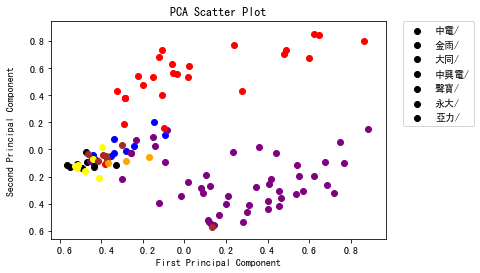

In [99]:
colors = ['black', 'blue', 'purple', 'yellow', 'brown', 'red', 'orange', 'gray', 'lime', 'cyan']
#    ["中電/", "金雨/", "大同/", "中興電/", "聲寶/", "東元/", "永大/", "亞力/"]

for i in range(len(folders)):
    for index in range(len(company_names)):
        if company_names[index] == folders[i]:
            x = Y_sklearn_all[:, 0][index]
            y = Y_sklearn_all[:, 1][index]
            plt.scatter(x, y, c=colors[i])

plt.legend(folders , bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("PCA Scatter Plot")
plt.show()

### normal companies

In [100]:
normal_corpus = corpus2 + corpus5
normal_texts = txts_in_folder2 + txts_in_folder5
normal_names = ["大同"] * len(txts_in_folder2) + ["永大"] * len(txts_in_folder5)
Y_sklearn_normal = analyze1(normal_names, normal_corpus, normal_texts)

tfidf.shape:  (74, 66)
----237120180313.txt NEWS---- 大同
大同 0.7744364410062893 0 20
未來 0.5009813907931056 0 34
目前 0.21738210995007098 0 39
----237120180324.txt NEWS---- 大同
億元 0.23665148699109445 1 4
大同 0.5786901272089447 1 20
市場派 0.2007002905237948 1 24
經營權 0.3010504357856922 1 42
股票 0.5759284467368861 1 47
----237120180326.txt NEWS---- 大同
以上 0.2333895819428811 2 3
公司 0.7686603668881985 2 5
去年 0.21095854967944128 2 11
台北 0.24398072433572357 2 15
增加 0.2333895819428811 2 19
未來 0.2385457315807666 2 34
相關 0.2150620941052106 2 40
超過 0.24398072433572357 2 59
----237120180328.txt NEWS---- 大同
大同 0.5727461156916417 3 20
市場派 0.611598407201269 3 24
林蔚山 0.5603401821243171 3 35
----237120180330.txt NEWS---- 大同
去年 0.22015106401016216 4 11
大同 0.4617859764112713 4 20
指出 0.3637976970934432 4 29
提出 0.22443342029730404 4 30
股東 0.6157146352150283 4 45
董事會 0.33651172844045124 4 50
重大 0.26060827754980154 4 63
----237120180621.txt NEWS---- 大同
公司 0.2240525972466101 5 5
大同 0.34395474762429845 5 20
提出 0.62687271

/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



每股 0.36815395033728765 29 36
經營權 0.20511377397410177 29 42
股價 0.29250389668537424 29 44
股票 0.24524723104316193 29 47
證券 0.2942966772517943 29 56
資金 0.3594388752249872 29 58
----提前改選_180109_自由時報.txt NEWS---- 大同
去年 0.30351072123800216 30 11
大同 0.477480072791212 30 20
市場派 0.47839652679800465 30 24
持股 0.37616159814855027 30 28
林蔚山 0.24654486753232777 30 35
股東 0.2652667071062289 30 45
股票 0.34320100868318176 30 47
----本周連續3個交易日股價拉紅K棒20180913.txt NEWS---- 大同
億元 0.21377791715494876 31 4
公司派 0.22161116960446958 31 7
召開 0.3587816298499986 31 13
大同 0.48254472293005024 31 20
市場派 0.5439047600260953 31 24
經營權 0.3626031733507302 31 42
股東 0.48254472293005024 31 45
臨時會 0.2545083024891761 31 48
----林家涉掏空尚化_180201_工商時報.txt NEWS---- 大同
公司 0.3087474343321681 32 5
取得 0.4067309647987798 32 12
林蔚山 0.44052230479628685 32 35
股東 0.4265767611907455 32 45
董事會 0.4662812121420356 32 50
通過 0.22026115239814342 32 61
----林蔚山挨告背信_180201_自由時報.txt NEWS---- 大同
公司 0.21519596861603515 33 5
合作 0.5371510673395253 33 17
相關 0.36

In [101]:
abnormal_corpus = corpus0 + corpus1 + corpus3 + corpus4 + corpus6
abnormal_texts = txts_in_folder0 + txts_in_folder1 + txts_in_folder3 + txts_in_folder4 + txts_in_folder6
abnormal_names = ["中電"] * len(txts_in_folder0) + ["金雨"] * len(txts_in_folder1) + ["中興電"] * len(txts_in_folder3) + ["聲寶"] * len(txts_in_folder4) + ["亞力"] * len(txts_in_folder6)

Y_sklearn_abnormal = analyze1(abnormal_names, abnormal_corpus, abnormal_texts)

tfidf.shape:  (35, 75)
----20180329_1611_中電去年轉虧為盈.txt NEWS---- 中電
中電 0.26256058433125484 0 1
照明 0.6301454023950115 0 44
發展 0.27401026658687294 0 49
節能 0.26256058433125484 0 53
能源 0.22933384248599434 0 59
----20180330_1611_中電漲逾半根停板.txt NEWS---- 中電
中電 0.2317566070074574 1 1
億元 0.2607042666683733 1 6
公司 0.2607042666683733 1 8
去年 0.2607042666683733 1 11
照明 0.5793915175186436 1 44
產品 0.2061845467735645 1 47
系統 0.2317566070074574 1 54
----20180410_1611_中國電器轉投資中電開發.txt NEWS---- 中電
中電 0.5185854118189759 2 1
照明 0.4714412834717963 2 44
環境 0.25736307993565666 2 46
產品 0.2097111892906079 2 47
系統 0.23572064173589816 2 54
銷售 0.2160528329553304 2 70
開發 0.318196117051601 2 71
----20180410_1611_中電拓展綠智能新版圖.txt NEWS---- 中電
中電 0.5070130496992051 3 1
億元 0.21123767958932615 3 6
智能 0.4115399240372387 3 40
照明 0.5070130496992051 3 44
產品 0.20047517802856862 3 47
----20180425_1611_中電秀先進、智慧、節能產品.txt NEWS---- 中電
中電 0.22579156267578526 4 1
應用 0.3233628216531713 4 27
智慧 0.2606670050430485 4 39
照明 0.6773746880273558 4

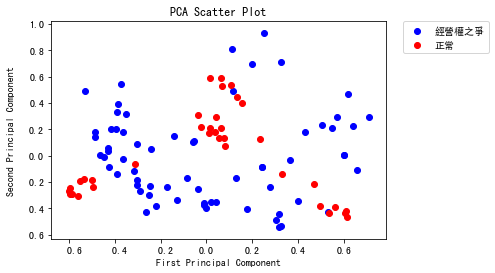

In [92]:
plt.scatter(Y_sklearn_normal[:,0], Y_sklearn_normal[:,1], c=colors[1])
plt.scatter(Y_sklearn_abnormal[:,0], Y_sklearn_abnormal[:,1], c=colors[5])
devided = ["經營權之爭", "正常"]
plt.legend(devided , bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("PCA Scatter Plot")
plt.show()